In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

# Set a seed for reproduceability
seed = 42

## Tokenizer, dataset, and embedding model

In this notebook, we review how to import a tokenizer, dataset and create our simplest model to train: an embedding model.  

### Loading the Cosmo2 tokenizer

Let's begin with loading a tokenizer.  The defualt LLama2 tokenizer is perfectly fine, but the nice people at Huggingface have a more up-to-date tokenizer, HuggingFaceTB/cosmo2-tokenizer, they use for the SmolLM models, which like our repo is based off of the LLama framework. We will use use the same. 

If this does not make sense what we are doing, please watch Andrej Kaparty's videos described in the Readme. We will leave it to his videos to explain what a tokenizer is, and how you might code one yourself.  We will just start from the beginning with a modern tokenizer used in the real world. 

The default context length for this tokenizer is 2048.  We will change that to 512 because we are training a simpler model.  Why 512?  For one, that was the orignal context length used in the GPT model.  Second, because the average paragraph has ~200 words, and there are roughly 2 tokens per word, so 512 ensures our model can at least understand paragraphs.  We will discuss how to increase the context length after training the initial models later like they do in the Llama 3 paper. 

See [the SmolLM settings](https://github.com/huggingface/smollm/blob/main/pre-training/smollm2/config_smollm2_135M.yaml) for more info on the SmolLM tokenizer, dataset, and other model choices if you want to explore further.

In [2]:
# 512 is a good minimal context length in principle large enough to understand paragraphs
context_length = 512

# The original Llama 2 tokenizer is available from Huggingface, but we will use the more
# up-to-date Cosmo2 toenizer provided by Huggingface for the Llama-like SmolLM models
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/cosmo2-tokenizer")
tokenizer.model_max_length = context_length
# There are times we need to pad.  We will make the padding token the same one that 
# signals end of sentance.
tokenizer.pad_token = tokenizer.eos_token

### Loading the Cosmo2 dataset

We do not have access to the exact dataset used by Llama, some of which may be proprietary to Meta. We will use the Cosmo2 dataset provided by Huggingface used to train their LLama-like SmolLM models.  This dataset is quite large so we will use the streaming option to not have to download the whole thing.  If you must download, try to download a small portion of use a smaller dataset available on Huggingface like OpenWebtext. 

In [3]:
# Load dataset from hugging face in streaming mode.
dataset = load_dataset("HuggingFaceTB/smollm-corpus", "cosmopedia-v2", split="train", streaming=True)

# The dataset is an IterableDataset. The 'text' field is the feature we want.
print (dataset)

# Let's extract and look at the text from the first entry
item = next(iter(dataset))['text']
print ('\nHere is the text from the first entry:\n')
print (item)

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

IterableDataset({
    features: ['prompt', 'text', 'token_length', 'audience', 'format', 'seed_data'],
    num_shards: 104
})

Here is the text from the first entry:

 In today's ever-evolving world, technology has become an integral part of our lives, shaping the way we learn, work, and communicate. The COVID-19 pandemic has only accelerated this trend, forcing educational institutions worldwide to adapt quickly to remote learning models. As such, social studies integration in elementary education can greatly benefit from incorporating digital tools like those offered by Ruangguru's Online School. Let's explore how educators can effectively leverage these resources to create engaging and meaningful learning experiences for young students.

Firstly, let's define what we mean by social studies integration. Social studies encompasses various disciplines that help students understand their communities, societies, and the wider world around them. These subjects may include history, geograp

In [4]:
# Let's tokenize that text.
# The tokenizer by default 
x = tokenizer(item, truncation=True, padding=True, return_tensors='pt')

# As you can see the tokenizer has the tokens under 'input_ids'. It also creates 
# an attention mask to track which tokens to pay attention to.  IE, Not padding. 
print (x)

# Now let's look at the input_ids
print (x['input_ids'])


{'input_ids': tensor([[  533,  1834,   506,  2042,    29, 24186,   905,    28,  1835,   553,
          1438,   354, 10021,   599,   282,   653,  2397,    28,  5929,   260,
           970,   392,   835,    28,   746,    28,   284,  5865,    30,   378,
          7191,    29,    33,    41,  8832,   553,   805, 18438,   451,  4213,
            28, 14072,  4096,  4679,  4969,   288,  2930,  3112,   288,  6431,
          1380,  2859,    30,  1032,   715,    28,  1329,  2157,  7657,   281,
         11289,  1888,   416,  6899,  3724,   429,  6457,  3182,  2549,   702,
           967,  5340,   411, 20139,   604,    87, 16634,   506,  8646,  3056,
            30,  2959,   506,  2217,   638,  7537,   416,  4025, 17188,   623,
          1952,   288,  1464,  4798,   284,  6579,  1380,  2647,   327,  1805,
          1058,    30,   198,   198, 21028,    28,  1303,   506,  5879,   732,
           392,  1441,   411,  1329,  2157,  7657,    30,  4758,  2157, 15868,
          1461, 10578,   338,   724,  

In [5]:
# Let's check to make sure the tokenized text matechs the above
print (tokenizer.decode(x['input_ids'][0]))

# It appeads to check out

 In today's ever-evolving world, technology has become an integral part of our lives, shaping the way we learn, work, and communicate. The COVID-19 pandemic has only accelerated this trend, forcing educational institutions worldwide to adapt quickly to remote learning models. As such, social studies integration in elementary education can greatly benefit from incorporating digital tools like those offered by Ruangguru's Online School. Let's explore how educators can effectively leverage these resources to create engaging and meaningful learning experiences for young students.

Firstly, let's define what we mean by social studies integration. Social studies encompasses various disciplines that help students understand their communities, societies, and the wider world around them. These subjects may include history, geography, civics, economics, sociology, and anthropology. By integrating social studies into the curriculum, we aim to foster critical thinking skills, promote cultural awar

### Prepare tokenized dataset for training

To train a model, we need the data to come out in batches of tokens.  To do this we need to map the dataset to tensors of shape (batch_size, context_length).

We can do that as follows.

In [6]:
# Set batch size
batch_size = 16


# Create a tokenize fundtion.
def tokenize(item):
    x = tokenizer(
        item['text'],
        truncation=True,
        padding=True,
        max_length=context_length,
        return_tensors="pt",
    )

    return x


tokenized_dataset = dataset.map(
    tokenize, batched=True, remove_columns=dataset.column_names
)
train_dl = DataLoader(dataset=tokenized_dataset, batch_size=batch_size)

In [7]:
# Let's text.  We should have an input_id field and attention_mask field 
# of shape (batch_size, context_length)
x = next(iter(train_dl))

print (x)
print (x['input_ids'].shape)

{'input_ids': tensor([[  533,  1834,   506,  ...,  6524,   940,    28],
        [ 6682,    42,   198,  ...,    30, 17897,  5076],
        [ 4281,    42, 21236,  ..., 32846,   618,   253],
        ...,
        [ 7606,    42, 24411,  ..., 24312,    28,   392],
        [22419, 18452,    28,  ...,  1798,    28, 18452],
        [ 4281,   216,    33,  ..., 33149,  2254,    28]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}
torch.Size([16, 512])


In [8]:
# Once again, let's make sure we are getting back the right results. 
for i, item in enumerate(dataset):
    print (f"\nOriginal entry {i} text is: {item['text'][:60]}")
    print (f"Tokenized entry {i} text is: {tokenizer.decode(x['input_ids'][i][:15])}")
    if i > 2:
        break

# Looks good


Original entry 0 text is:  In today's ever-evolving world, technology has become an in
Tokenized entry 0 text is:  In today's ever-evolving world, technology has become an integral part of

Original entry 1 text is:  Introduction:
In today's world, cooking has evolved beyond 
Tokenized entry 1 text is:  Introduction:
In today's world, cooking has evolved beyond traditional methods such

Original entry 2 text is:  Chapter: Cooking Up Comfort: Chemotheapy-Induced Nausea Rel
Tokenized entry 2 text is:  Chapter: Cooking Up Comfort: Chemotheapy-Induced Nausea

Original entry 3 text is:  Chapter 7: Navigating Orphanage Life - A Safe Haven or a Sp
Tokenized entry 3 text is:  Chapter 7: Navigating Orphanage Life - A Safe Haven or a


### Building embedding model

Now that the dataset and tokenizer seem to be working, we need to construct a model. At first let's do the simplest thing: let's create a model that maps the tokens into an embedding space of dimension 576 to be consistant with SmolLM mentioned above.  Then let's map back.

Also, we will try and keep these model sizes consistant at ~55M parameters.  This we we can see if improvement is coming from model size or if something about the archetecture is aiding learning. 

In [9]:
# We will inherit from Pytorch's Module class
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size: int, n_embed: int):
        super().__init__()

        # Map tokens to embedding space with dimension n_embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim=n_embed)

        # Now map back to make prediction for next tokens, called logits.  The layer that
        # does this is traditionally a linear layer called the lannguage model head.
        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.embedding.weight = self.lm_head.weight
        

    # Pytorch Modules have a forward method that is what is executed when the model is called
    # The input is the (batch, tokens) tensor and a (batch, logits) tensor is returned
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        logits = self.lm_head(x)
        return logits

In [10]:
# Let's create the model
model = EmbeddingModel(vocab_size = tokenizer.vocab_size, n_embed=832)

# Let's see how many parameters we have
print (sum([p.numel() for p in model.parameters()])/1.0e6)


40.894464


### The Training Loop

Let's make the training loop as simple as possible.  Let's try to keep it as close to the pytorch quickstart example, only adding what is required for large language model traing: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

A few things that need to be added:

* Some items are named to standard conventions like pred -> logits
* LLama is trained with AdamW
* The optimizer is Cross Entropy
* Labels are the same as the input_ids, except we shift them so that we compare to the next token.

If any of this does not make sense, again please watch Andrej's videos

In [ ]:
device = "mps"
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

num_params = sum([p.numel() for p in model.parameters()]) / 1.0e6
print(f"This model has {num_params:.2f}M  params")
print(
    f"The vocab size is {tokenizer.vocab_size}, meaning the initial loss should be ~{math.log(tokenizer.vocab_size):.3f}"
)
model.train()
losses = []
for step, batch in enumerate(train_dl):

    # Get data
    x = batch["input_ids"].to(device)
    att_mask = batch["attention_mask"].to(device)

    # Compute prediction error
    logits = model(x)

    # Shift to compare loss correctly
    shifted_logits = logits[:, :-1].contiguous()
    labels = x[:, 1:].contiguous()
    loss = loss_fn(shifted_logits.view(-1, shifted_logits.size(-1)), labels.view(-1))
    losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if step % 500 == 0:
        print(
            f"Step: {step:>5d},  Tokens:{batch_size*context_length*(step+1)/1.0e6:>7.3f}M,  Loss: {loss.item():>7.3f}, Perplexity:  {math.exp(loss.item()):>7.1f}"
        )
    if (step + 1) % 12500 == 0:
        break

This model has 40.89M  params
The vocab size is 49152, meaning the initial loss should be ~10.803
Step:     0,  Tokens:  0.008M,  Loss:   7.571, Perplexity:  1941.2
Step:     5,  Tokens:  0.049M,  Loss:   7.259, Perplexity:  1421.4
Step:    10,  Tokens:  0.090M,  Loss:   7.553, Perplexity:  1907.1
Step:    15,  Tokens:  0.131M,  Loss:   7.557, Perplexity:  1913.4
Step:    20,  Tokens:  0.172M,  Loss:   6.849, Perplexity:  943.0
Step:    25,  Tokens:  0.213M,  Loss:   7.755, Perplexity:  2332.2


KeyboardInterrupt: 

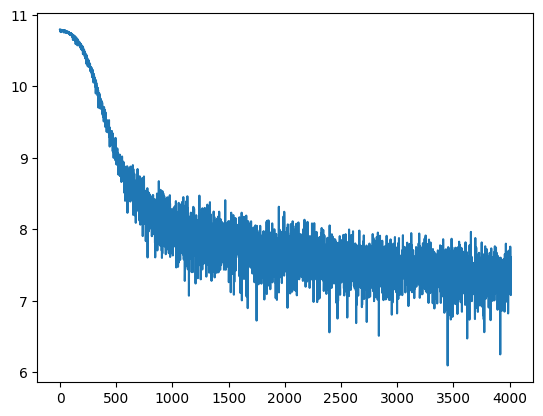

In [12]:
plt.plot(losses)

In [39]:
# Assuming the embedding layer is already trained
layer = model.embedding.to('cpu')

# Get the embedding for 'king' (e.g., assuming 'king' corresponds to token index 0)
k = 200
word = 'woman'

print (f"Input ids for {word} is {tokenizer(word)['input_ids']}")

word_index = tokenizer(word)['input_ids'][0]
word_embedding = layer(torch.tensor(word_index)).detach()  # Get the embedding for 'king'

# Get all embeddings
all_embeddings = layer.weight.detach()  # Extract all embeddings


# Compute cosine similarity between 'king' and all other tokens
cosine_similarities = F.cosine_similarity(word_embedding.unsqueeze(0), all_embeddings, dim=1)

# Get the indices of the 10 most similar tokens (excluding 'king' itself)
top_k = torch.topk(cosine_similarities, k=k+1)  # Top 11 because 'king' will be in the list
top_k_indices = top_k.indices[top_k.indices != word_index][:k]  # Exclude 'king'


# Print the 10 closest tokens and their similarities
print(f"Top 25 closest tokens to {word} by cosine similarity: ")
ii = 0
for idx in top_k_indices:
    #print(idx.item())
    idx_word = tokenizer.decode(idx.item()).replace('\n','')
    if len(idx_word) > 4:
        print(f"Token: {idx.item():5d}, {idx_word:>14s},   Similarity: {cosine_similarities[idx].item():.4f}")
        ii += 1
        if ii > 24:
            break





Input ids for woman is [24626]
Top 25 closest tokens to woman by cosine similarity: 
Token: 13898,         testim,   Similarity: 0.1931
Token:  7346,         athlet,   Similarity: 0.1910
Token: 33000,       passport,   Similarity: 0.1748
Token: 21852,         racist,   Similarity: 0.1732
Token: 32189,  hydroelectric,   Similarity: 0.1726
Token: 28217,      budgeting,   Similarity: 0.1691
Token: 33278,        founded,   Similarity: 0.1680
Token: 46275,          Sofia,   Similarity: 0.1670
Token:  5611,           mort,   Similarity: 0.1670
Token: 42724,       judgment,   Similarity: 0.1663
Token: 49037,        fetched,   Similarity: 0.1651
Token: 15245,       economic,   Similarity: 0.1649
Token: 15896,      publisher,   Similarity: 0.1640
Token: 42079,       truthful,   Similarity: 0.1638
Token: 43285,        caribou,   Similarity: 0.1618
Token: 24343,        Western,   Similarity: 0.1603
Token: 22858,      organized,   Similarity: 0.1588
Token: 23614,     functional,   Similarity: 0.15

In [40]:
distances = torch.norm(all_embeddings - word_embedding, dim=1)  # Compute L2 norm (Euclidean distance)

# Get the indices of the 10 closest tokens (excluding 'king' itself)
top_k = torch.topk(-distances, k=k+1)  # Use negative distances to mimic \"closest\"
top_k_indices = top_k.indices[top_k.indices != word_index][:k]  # Exclude 'king'

# Print the 10 closest tokens and their distances
print(f"\nTop 25 closest tokens to {word} by distance: ")
ii = 0
for idx in top_k_indices:
    #print(idx.item())
    idx_word = tokenizer.decode(idx.item()).replace('\n','')
    if len(idx_word) > 4:    
        print(f"Token: {idx.item():5d}, {tokenizer.decode(idx.item()).replace('\n',''):>14s},   Distance: {distances[idx].item():.2f}")
        ii += 1
        if ii > 24:
            break



Top 25 closest tokens to woman by distance: 
Token: 29386,      migraines,   Distance: 0.83
Token: 11814,       minister,   Distance: 0.83
Token: 33000,       passport,   Distance: 0.83
Token: 32059,          mango,   Distance: 0.84
Token: 28650,           visa,   Distance: 0.84
Token: 16336,         diesel,   Distance: 0.84
Token: 38079,         Safari,   Distance: 0.84
Token: 34989,     defendants,   Distance: 0.84
Token: 21852,         racist,   Distance: 0.84
Token: 40498,        glazing,   Distance: 0.84
Token:  8016,         Victor,   Distance: 0.84
Token: 47169,       tenacity,   Distance: 0.84
Token: 25708,      ingestion,   Distance: 0.84
Token: 10982,          mates,   Distance: 0.84
Token: 18090,     provincial,   Distance: 0.85
Token: 32309,        curator,   Distance: 0.85
Token: 31376,         tattoo,   Distance: 0.85
Token: 35278,           envy,   Distance: 0.85
Token: 23763,           clan,   Distance: 0.85
Token: 30512,     vigorously,   Distance: 0.85
Token: 47532, 

In [50]:
# We will inherit from Pytorch's Module class
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size: int, n_embed: int):
        super().__init__()

        # Map tokens to embedding space with dimension n_embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim=n_embed)

        self.fft1 = nn.Sequential(nn.Linear(n_embed, 3*n_embed),
                                 nn.ReLU(),
                                 nn.Linear(n_embed, 3*n_embed))
        
        self.fft2 = nn.Sequential(nn.Linear(n_embed, 3*n_embed),
                                 nn.ReLU(),
                                 nn.Linear(n_embed, 3*n_embed))
                               

        # Now map back to make prediction for next tokens, called logits.  The layer that
        # does this is traditionally a linear layer called the lannguage model head.
        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.embedding.weight = self.lm_head.weight
        

    # Pytorch Modules have a forward method that is what is executed when the model is called
    # The input is the (batch, tokens) tensor and a (batch, logits) tensor is returned
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.fft1(x)
        x = self.fft2(x)
        logits = self.lm_head(x)
        return logits
    
# Let's create the model
model = EmbeddingModel(vocab_size = tokenizer.vocab_size, n_embed=704)

# Let's see how many parameters we have
print (sum([p.numel() for p in model.parameters()])/1.0e6)


40.558848
